In [51]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import networkx as nx
import pandas as pd
import nltk
import copy

In [79]:
def import_file(path):
    with open(path) as f:
        content = f.readlines()

    # Process header information
    header = [nltk.RegexpTokenizer(r"\w+").tokenize(line) for line in content[:3]]

    # Process content
    content = [nltk.RegexpTokenizer(r"\w+").tokenize(line) for line in content[3:]]
    df = pd.DataFrame(content[1:], columns=content[0])
    df["FromNodeId"] = df["FromNodeId"].astype(int)
    df["ToNodeId"] = df["ToNodeId"].astype(int)

    return header, df

In [80]:
def create_graph(content):
    G = nx.from_pandas_edgelist(content,source = "FromNodeId", target = "ToNodeId")
    return G.to_directed()


In [81]:
def update_authorities_or_hubs(G, a, b, type_):
    norm = 0
    for node in G.nodes():
        if type_ == "authority":
            edges = G.in_edges(node)
        else:
            edges = G.out_edges(node)
        n_edges = len(edges)
        a[node] = sum([b[edge[0 if type_ == "authority" else 1]] for edge in edges])
        norm += a[node] ** 2

    norm = np.sqrt(norm)

    for node in G.nodes():
        a[node] /= norm
        
def HITS(G, max_iters=100):
    n = G.number_of_nodes()
    hub = {node: 1 for node in G.nodes()}
    authority = {node: 1 for node in G.nodes()}
    e1 = []
    e2 = []

    cur_auth = authority.copy()
    cur_hub = hub.copy()
    
    for _ in range(max_iters):
        update_authorities_or_hubs(G,authority,hub,"authority")
        update_authorities_or_hubs(G,hub,authority,"hub")
        
        e1.append(mse(list(authority.values()),list(cur_auth.values())))
        e2.append(mse(list(hub.values()),list(cur_hub.values())))

        cur_auth = authority.copy()
        cur_hub = hub.copy()
        
        if e1[-1] < 1e-20 and e2[-1] < 1e-20:
            break

    return authority, hub, e1[1:], e2[1:]

In [82]:
def PageRank(G, d=0.85, max_iters=100):
    n = G.number_of_nodes()
    rank = {node: 1/n for node in G.nodes()}
    node_val = {node: 0 for node in G.nodes()}
    error = []
    
    for _ in range(max_iters):
        for node in G.nodes():
            out = G.out_edges(node)
            n_edges = len(out)
            for edge in out:
                node_val[edge[1]] += rank[edge[0]] / n_edges

        for node in G.nodes():
            node_val[node] = (1-d)/n + d*node_val[node]
        
        e = mse(list(rank.values()), list(node_val.values()))
        error.append(e)
        
        rank = node_val.copy()
        node_val = {node: 0 for node in G.nodes()}
        
        if e < 1e-15:
            break
        
    return error, rank


In [83]:
def sortDict(d, title):
    sorted_dict = {key: value for key, value in sorted(d.items(), key=lambda item: item[1], reverse=True)}
    print(f"Top 10 {title} scores:")
    for i, (key, val) in enumerate(sorted_dict.items()):
        if i < 10:
            print(f"{key}\t{val}")
        else:
            break
    print()
    return sorted_dict

In [84]:
path = "Wiki-Vote.txt"
meta, content = import_file(path)
G = create_graph(content)

In [85]:
error, rank = PageRank(G)

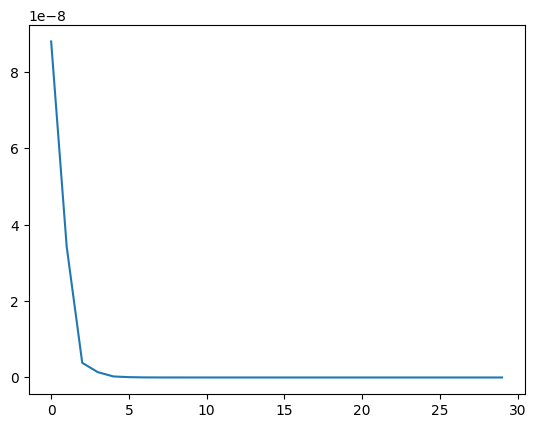

In [86]:
plt.plot(error)

In [87]:
authority, hub, e1, e2 = HITS(G)

In [88]:
print(e1)

[4.9382220458352065e-06, 1.536110431170553e-07, 8.137574511399859e-09, 4.780125636812147e-10, 3.031384738038773e-11, 2.12809473019362e-12, 1.7473615771530638e-13, 1.758104386338244e-14, 2.1393846990311195e-15, 2.956732030945261e-16, 4.367757711317428e-17, 6.6505165026709295e-18, 1.0257534879404805e-18, 1.590522454513601e-19, 2.4716057513132743e-20, 3.844161163295721e-21]


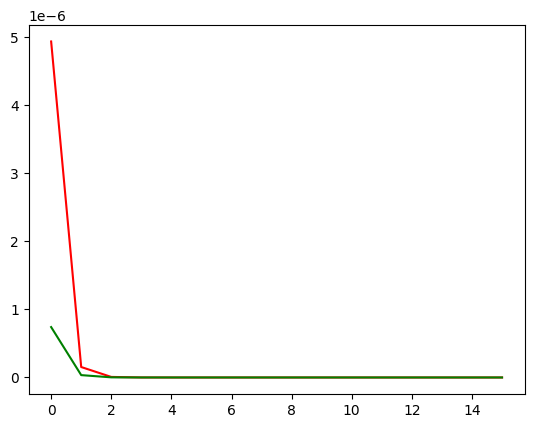

In [89]:
plt.plot(e1,'r',e2, 'g')

In [90]:
rank = sortDict(rank, "rank")
authority = sortDict(authority, "authority")
hub = sortDict(hub, "hub")

top 10 rank scores :
2565 	 0.0043372949187308815
11 	 0.003017206269367328
766 	 0.002968177479349323
457 	 0.002963411320667381
4037 	 0.002878218886740526
1549 	 0.0028581648714845506
1166 	 0.002669208905008099
2688 	 0.0023843472728713416
15 	 0.002163159726354969
1374 	 0.002131987766043142

top 10 authority scores :
2565 	 0.15769611748358103
766 	 0.13015243025685455
1549 	 0.12938941353080033
1166 	 0.11950594168986171
2688 	 0.11008403659853248
457 	 0.10999186611635883
3352 	 0.09179709631226124
11 	 0.08956574261869124
1151 	 0.08717924518500951
1374 	 0.08692950770481205

top 10 hub scores :
2565 	 0.157696117537377
766 	 0.13015243029945367
1549 	 0.12938941344572305
1166 	 0.11950594165584667
2688 	 0.11008403661789759
457 	 0.10999186615700852
3352 	 0.09179709627666102
11 	 0.08956574247014454
1151 	 0.08717924513642718
1374 	 0.08692950771109112



In [91]:
meta

['# Directed graph (each unordered pair of nodes is saved once): Wiki-Vote.txt \n',
 '# Wikipedia voting on promotion to administratorship (till January 2008). Directed edge A->B means user A voted on B becoming Wikipedia administrator.\n',
 ['Nodes', '7115', 'Edges', '103689']]